# Machine Learning Engineer Nanodegree - Capstone Project
## PART 4: Averages of Word2vec's vectors

**Author:** Giacomo Sarchioni

## Introduction
Before diving into complex architectures, one strategy - as explained in the *Bag of Words Meets Bags of Popcorn* tutorial - would be to:

* initialise a zero vector with the same dimension of our word vectors (e.g. 300). Let's call this vector `v`;
* loop throuhg every word in a review. If the word has been vectorised in our word2vec model, then we add each dimension of the word vector representation to the `v` (otherwise we move to the next word in the review;
* we divide `v` by the number of vector words we added (we kind of do an average).
  
In the end, we are taking the average of our word vectors within a given review. In other words, given a vector representation of words, if we had to represent a sentence (a document, a review) as a vector with the same number of dimensions, what would be the most immediate thing to do? Well, take the average of all its word vector components.  
At the end of this process, we would get a single 300-D (if word2vec size is 300) vector which represents a single review.  
We can then feed such input data to the same Logistic Regression classifier defined before.  

In [2]:
# Module imports
import pickle as pkl
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from average_word2vec import *
from sklearn.linear_model import LogisticRegression
from roc_chart import ROCChart
from naive_classifier import NaiveModel
from sklearn.externals import joblib

random_seed = 42

## Import data

In [3]:
# Load reviews
with open('reviews/sentiment_reviews/sentiment.pkl', 'rb') as f:
    sentiment_reviews = pkl.load(f)
    
# Load indexes
with open('split_indexes/indexes.pkl', 'rb') as f:
    indexes = pkl.load(f)

In [5]:
# Extract scores
scores = sentiment_reviews.adj_score.values

# Extract non-test and test scores
non_test_scores = scores[indexes['non_test']]
test_scores = scores[indexes['test']]

# Extract train and validation scores
train_scores = non_test_scores[indexes['train']]
val_scores = non_test_scores[indexes['val']]

# Extract parser_two_reviews 
parser_two_reviews = sentiment_reviews.loc[:,'parser_two'].values

# Extract parser_one_reviews 
parser_one_reviews = sentiment_reviews.loc[:,'parser_one'].values

In [9]:
# Load word2vec skip-gram model
w2v_skipgra_model = Word2Vec.load('word2vec_models/default_sgram_word2vec.hdf5')

## Transform reviews into averages of Word2vec's vectors

In [10]:
# Transform all reviews
parser_two_reviews_w2v_avg = vectorise_review_set(parser_two_reviews,
                                                  w2v_skipgra_model,
                                                  vectors_vocab = set(w2v_skipgra_model.wv.index2word), 
                                                  wv_dimension=300)

Let's have a look at one transformed review as an example.

In [12]:
parser_two_reviews_w2v_avg[0].shape

(300,)

In [13]:
# Extract non test parser two reviews and scores
non_test_parser_two_reviews_w2v_avg = parser_two_reviews_w2v_avg[indexes['non_test']]
test_parser_two_reviews_w2v_avg = parser_two_reviews_w2v_avg[indexes['test']]

# Extract train and validation parser-two reviews
train_parser_two_reviews_w2v_avg = non_test_parser_two_reviews_w2v_avg[indexes['train']]
val_parser_two_reviews_w2v_avg = non_test_parser_two_reviews_w2v_avg[indexes['val']]

### Performance on validation data

In [22]:
w2v_avg_log_reg = LogisticRegression(random_state=random_seed, solver='sag', n_jobs=-1)
w2v_avg_log_reg.fit(train_parser_two_reviews_w2v_avg, train_scores)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
# Predict sentiment on validation data
w2v_avg_val_pred = w2v_avg_log_reg.predict(val_parser_two_reviews_w2v_avg)

AUC score for Avg of Word2vec is 0.7746


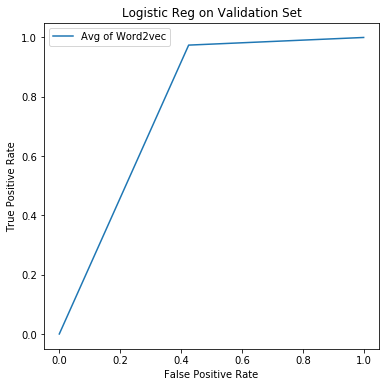

In [24]:
# Plot chart
w2v_avg_val_chart = ROCChart(val_scores,
                             [w2v_avg_val_pred],
                             ['Avg of Word2vec'], 'Logistic Reg on Validation Set')
w2v_avg_val_chart.plot()

In [55]:
# Save average of Word2vec's vectors model
joblib.dump(w2v_avg_log_reg, 'avg_w2v_model/avg_w2v_lr_model.pkl')

['avg_w2v_model/avg_w2v_lr_model.pkl']